In [48]:

import os
import torch
import gc

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()        
    torch.cuda.ipc_collect()


try:
    %run setup_paths
except:
    %run notebooks/setup_paths
    
os.getcwd()

'c:\\Projects\\saliency'

In [29]:
%run src/dataset

isrc = ImagenetSource("imagenet_samples", "*")
all_images = isrc.get_all_images()


(-0.5, 223.5, 223.5, -0.5)

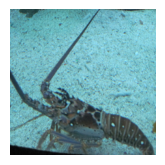

In [67]:
%run src/benchmark
image_name = "ILSVRC2012_val_00012455" ## lobster
#image_name = "ILSVRC2012_val_00028649"
image_info = all_images[image_name]
image_path = image_info.path
targetidx = image_info.target
img=Image.open(image_path)
img=img.resize((224,224))  
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis('off')


In [68]:
%run src/benchmark
me = ModelEnv('resnet50')

inp = me.get_image(image_path)
logits = me.model(inp).cpu()
topidx = int(torch.argmax(logits))

print(topidx, targetidx)

C:\Users\zivhd\anaconda3\envs\mcmc\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zivhd\anaconda3\envs\mcmc\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


123 123


In [38]:
sals_dict = {}

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


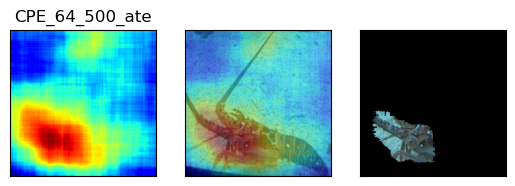

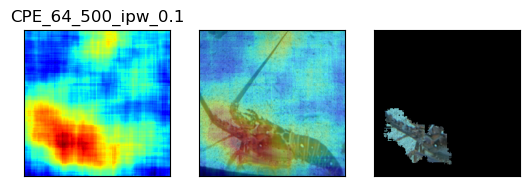

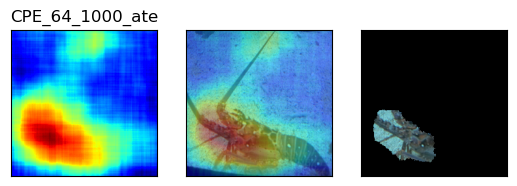

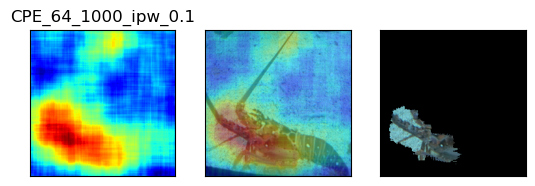

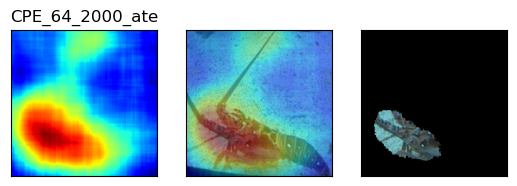

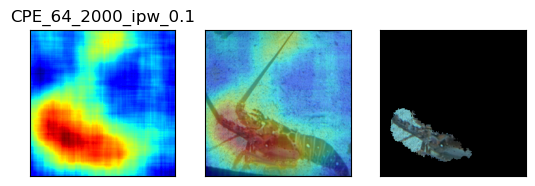

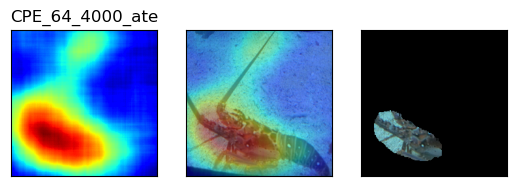

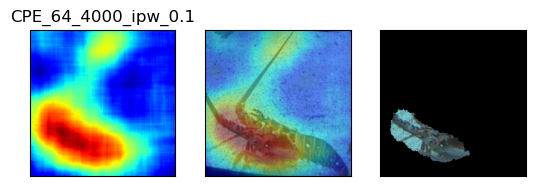

In [45]:
%run src/intutils
%run src/cpe

segsize=64
algo = IpwSalCreator(f"CPE_{segsize}", [500,1000,2000,4000], segsize=segsize, batch_size=32)
res = algo(me, inp, topidx)
show_sal_dict(res, img)
sals_dict.update(res)


In [300]:

%run src/cpealt

simp = SimpGen(64, collect_masks=True)
simp.gen(me.narrow_model(topidx), inp, 1000)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.97it/s]


In [301]:
sal, var = simp.get_ate_sal()
sal.shape

torch.Size([1, 224, 224])

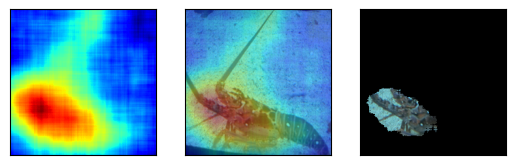

In [302]:
showsal(sal[0].cpu(), img)

In [303]:
all_masks = torch.concat(simp.all_masks)
all_masks.shape

torch.Size([1000, 224, 224])

In [304]:
## Prewitt Sobel and Scharr gradient 5x5 convolution matrices
## Expansion and implementation of a 3x3 soble
def gsobel(K):    
    arng = torch.arange(K, dtype=torch.float32)
    offs = arng-arng.mean()
    dist = offs.abs()    
    return torch.nan_to_num(offs / (dist.unsqueeze(0)**2 +  dist.unsqueeze(1)**2),0)

sblx = gsobel(31)
sbly = sblx.transpose(0,1)

In [305]:
import torch.nn.functional as F
isal = sal.cpu()
print(isal.shape)
ctx = F.conv2d(isal.unsqueeze(0), sblx.unsqueeze(0).unsqueeze(0), padding="same")[0,0]
cty = F.conv2d(isal.unsqueeze(0), sbly.unsqueeze(0).unsqueeze(0), padding="same")[0,0]

torch.Size([1, 224, 224])


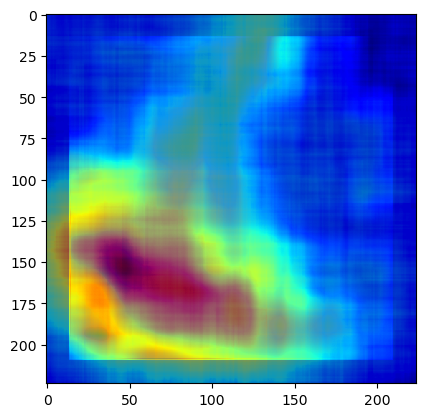

In [306]:
grad = (ctx**2 + cty**2)
pad = 14
zzz = torch.zeros(grad.shape)
zzz[ pad:-pad, pad:-pad]=grad[ pad:-pad, pad:-pad]
plt.imshow(zzz, cmap="jet")
plt.imshow(isal[0], cmap="jet", alpha=0.6)

In [347]:
csz = (ctx**2 + cty**2).sqrt()
cszbar = torch.quantile(csz, 0.01)
#torch.quantile(csz, 0.6)
dist = 31
offsx = (ctx*dist/csz).to(torch.int32)
offsy = (cty*dist/csz).to(torch.int32)
#offsx[175,25]


In [348]:
H, W = 224,224
idxx = offsx + torch.arange(W).unsqueeze(0)
idxy = offsy + torch.arange(W).unsqueeze(0)
isok = ((csz > cszbar) & (idxx >= 0) & (idxx < W) & (idxy >= 0) & (idxy < H))
isok.sum() / (H*W)

tensor(0.9137)

In [349]:
msk = all_masks[1]
bmasks = all_masks[0:32]
msk.shape

torch.Size([224, 224])

In [350]:
torch.minimum(torch.arange(10), torch.tensor([8]))

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 8])

In [351]:
confidx = torch.maximum(torch.minimum(idxx.flatten()+idxy.flatten()*H, torch.tensor(H*W-1)), torch.tensor([0]))

mvals = msk.flatten().gather(0, confidx).reshape(msk.shape)

In [352]:
gidx = ((torch.arange(bmasks.shape[0]) * confidx.numel()).unsqueeze(1) + confidx.unsqueeze(0)).flatten()
ref = bmasks.flatten().gather(0, gidx).reshape(bmasks.shape)
print(ref.shape)


torch.Size([32, 224, 224])


In [353]:
if False:
    ooo = torch.arange(12).reshape(3,2,2)

    print(ooo)

    xi = torch.tensor([[0,0],[1,1]])
    yi = torch.tensor([[0,0],[0,1]])

    pos = yi.flatten()*2 + xi.flatten()
    print(pos)

    gidx = ((torch.arange(ooo.shape[0]) * pos.numel()).unsqueeze(1) + pos.unsqueeze(0)).flatten()
    print(gidx)
    ref = ooo.flatten().gather(0,gidx).reshape(ooo.shape)
    ref

    #ooo.flatten(1).gather(1, ppp.unsqueeze(0)).reshape(ooo.shape)

In [354]:
#mbin 

icats = torch.arange(4).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
gidx = None
prev_bmask_shape = None
s_saliency = None
s_weights = None

for idx, bmasks in enumerate(simp.all_masks):
    
    if bmasks.shape != prev_bmask_shape:
        gidx = ((torch.arange(bmasks.shape[0]) * confidx.numel()).unsqueeze(1) + confidx.unsqueeze(0)).flatten()
        prev_bmask_shape = bmasks.shape
        
    ref = bmasks.flatten().gather(0, gidx).reshape(bmasks.shape)
    mout = simp.all_pred[idx]
    #print(mout)
    #print(bmasks.shape)
    ref = bmasks.flatten().gather(0, gidx).reshape(bmasks.shape)
    cat = ((bmasks > 0.5) * 1 + (ref > 0.5) * 2).unsqueeze(0)
    
    mbin = (icats == cat)
    #print(cat.shape, mout.shape, mbin.shape)
    saliency = (mout.squeeze(1).unsqueeze(0) * mbin).sum(dim=1)
    print(mbin.shape)
    weights = mbin.sum(dim=1)    
    if s_saliency is None:
        s_saliency = saliency
        s_weights = weights
    else:
        s_saliency += saliency
        s_weights += weights
    #break    
    #print(mbin.shape)
    #break
    
s_saliency.shape, s_weights.shape

torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 32, 224, 224])
torch.Size([4, 8, 224, 224])


(torch.Size([4, 224, 224]), torch.Size([4, 224, 224]))

In [355]:
cidx = torch.arange(4)
treatment_sal = s_saliency[(cidx & 1) == 1]
control_sal = s_saliency[(cidx & 1) == 0]
p_treatment_weights = s_weights[(cidx & 1) == 1]
p_control_weights = s_weights[(cidx & 1) == 0]

clip = 0.1
t_clipping = torch.tensor([clip])    
c_clipping = torch.tensor([clip])    

treatment_prob =  torch.max(p_treatment_weights / (p_treatment_weights + p_control_weights + 1), t_clipping)
control_prob =  torch.max(p_control_weights / (p_treatment_weights + p_control_weights + 1), c_clipping)

ipw = (
    ((treatment_sal / treatment_prob).sum(dim=0) / (p_treatment_weights / treatment_prob).sum(dim=0)) -
    ((control_sal / control_prob).sum(dim=0) / (p_control_weights / control_prob).sum(dim=0)) ).unsqueeze(0)            

ipw.shape
#treatment_prob.shape, p_treatment_weights.shape, p_control_weights.shape, t_clipping.shape

torch.Size([1, 224, 224])

In [356]:
cate = (s_saliency[(cidx & 1) == 1].sum(dim=0) / s_weights[(cidx & 1) == 1].sum(dim=0)) - (s_saliency[(cidx & 1) == 0].sum(dim=0)/s_weights[(cidx & 1) == 0].sum(dim=0))
ipw.shape, isal.shape

(torch.Size([1, 224, 224]), torch.Size([1, 224, 224]))

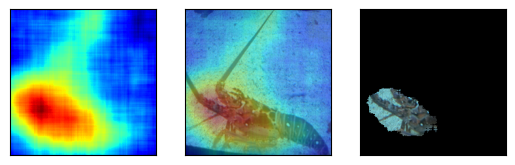

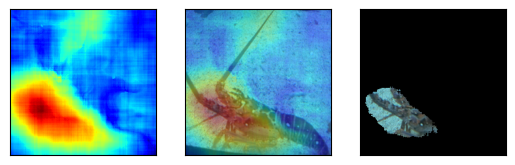

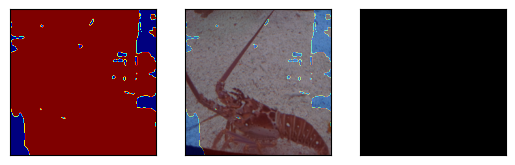

In [357]:
fsal = isal * (~isok) + ipw * (isok)
showsal(cate, img)
showsal(fsal[0], img)
showsal(isok*1.0, img)


In [358]:
import logging

logging.basicConfig(format='[%(asctime)-15s  %(filename)s:%(lineno)d - %(process)d] %(message)s', level=logging.DEBUG)

sals_dict = dict(ipw=fsal, ate=isal)
scores_dict = get_sal_scores(me, inp, sals_dict)


In [359]:
for key, stats in scores_dict.items():
    print(key, stats["del_auc"], stats["ins_auc"]), 
    

ipw 0.0524496523048136 0.7373638686092038
ate 0.05537670215332142 0.723784402066875


In [161]:
#run src/adaptors
#import pytorch_grad_cam 
#dir(pytorch_grad_cam)

ddd = [1,2,3]
import random
random.shuffle(ddd)
ddd

[3, 1, 2]

In [65]:
ee= 1000
f"{ee:x}"

'3e8'